### Import all necessary libraries
Here, we import all the necessary libraries required to create our classification model

In [1]:
import numpy as np
import pandas as pd

#For visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For text preprocessing
import nltk
from nltk.stem import PorterStemmer
import re
import string

#For feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#For other sklearn methods
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

### Data Reading
We read the training data for our model using pandas

In [2]:
data = pd.read_csv("dair_data.csv")
data.columns = ['id','Text','Emotion']
data.drop('id', axis = 1, inplace = True)
data.head()

,Text,Emotion
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


We visualize the dataset. There are total 416809 examples of data

In [3]:
data['Emotion'].value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: Emotion, dtype: int64

<AxesSubplot:xlabel='Emotion', ylabel='count'>

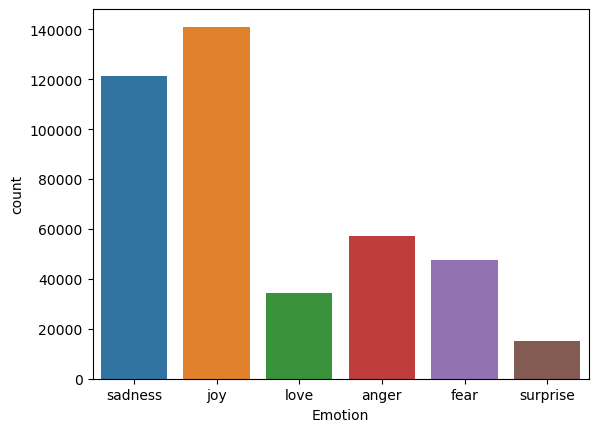

In [4]:
sns.countplot(x = 'Emotion', data = data)

### Text Preprocessing Steps

Here, we manually set the stopwords.

In [5]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
                "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',
                'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's",
                'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who',
                'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were',
                'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
                'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',
                'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
                'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
                'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only',
                'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
                'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't",
                'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
                "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
                'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

Different Functions for text cleaning

In [6]:
#Changing text to lowercase and removing punctuations and numbers
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)
    return text

#Removing extra spaces
def rem_wspaces(text):
    return ' '.join(text.split())

#Removing HTML tags and URLs
def rem_tags_urls(text):
    text = re.sub(r"http?://\S+|www.\.\S+", "", text)
    text = re.sub(r"https?://\S+|www.\.\S+", "", text)
    return re.sub(r'<.*?>','',text)

#Tokenize the sentences
def tokenize(text):
    text = text.strip('.')
    return text.split()

#Removing stopwords such as a, an, the, are, etc.
def rem_stopwords(text):
    t_text = tokenize(text)
    f_text = [word for word in t_text if word not in stopwords]
    return f_text

Call all the above functions from one single function

In [7]:
def text_preprocess(text):
    #Remove puctuations, numbers and convert string into lower case
    text = clean_text(text)
    #Remove HTML tags and URLs
    text = rem_tags_urls(text)
    #Remove whitespaces
    text = rem_wspaces(text)
    #Tokenize the text
    text = rem_stopwords(text)
    return text

Function for word stemming

In [8]:
ps = PorterStemmer()
def stem_text(text):
    word_tokens = tokenize(text)
    new_text = [ps.stem(words) for words in word_tokens]
    return new_text

Apply all the above functions to the data

In [9]:
data['Text'] = data['Text'].apply(text_preprocess)
data['Text'] = [' '.join(map(str, l)) for l in data['Text']] 
data['Text'] = data['Text'].apply(stem_text)
data['Text'] = [' '.join(map(str, l)) for l in data['Text']] 
data.head()

,Text,Emotion
0,feel aw job get posit succeed happen,sadness
1,im alon feel aw,sadness
2,ive probabl mention realli feel proud actual k...,joy
3,feel littl low day back,sadness
4,beleiv much sensit peopl feel tend compassion,love


Split the data into train and test set

In [10]:
X = data['Text']
y = list(data['Emotion'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f'The shape of training set : {np.shape(X_train)}')
print(f'The shape of test set : {np.shape(X_test)}')

The shape of training set : (333447,)
The shape of test set : (83362,)


### Text Feature Extraction

Apply Tfidf Vectorizer for feature extraction to convert the words into vector forms

In [12]:
vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Applying ML Algorithms

#### Multinomial Naive Bayes

Accuracy score : 71.78450612989131%

F1 score : 66.61218941067274

Cross validation Score is : 
[0.66214838 0.66028909 0.66488724 0.662488   0.66110845]

Confusion matrix :
[[ 4883   106  3318     0  3032     0]
 [  286  3114  3598     0  2378     0]
 [    1     2 27866     1   377     0]
 [    6     3  5326   803   715     0]
 [   15    12  1453     1 23023     0]
 [    2   240  2031     0   618   152]]


Classification report : 
              precision    recall  f1-score   support

       anger       0.94      0.43      0.59     11339
        fear       0.90      0.33      0.48      9376
         joy       0.64      0.99      0.78     28247
        love       1.00      0.12      0.21      6853
     sadness       0.76      0.94      0.84     24504
    surprise       1.00      0.05      0.10      3043

    accuracy                           0.72     83362
   macro avg       0.87      0.48      0.50     83362
weighted avg       0.79      0.72      0.67     83362





<AxesSubplot:>

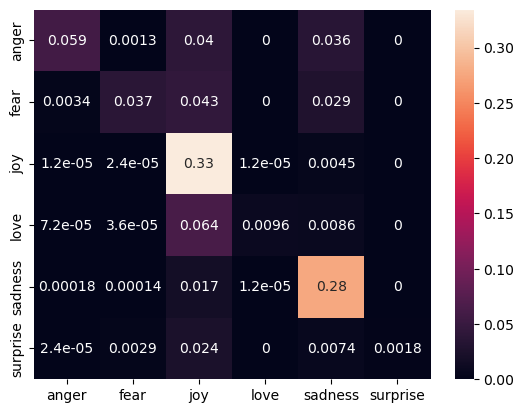

In [17]:
#Applying model and fitting training data
nb = MultinomialNB()
nb.fit(X_train_vectorized,y_train)

#Predicting the output target
y_nb = nb.predict(X_test_vectorized)
cross_val_score_nb = cross_val_score(nb, X_test_vectorized, y_test , cv = 5)

#Checking for accuracy
print(f'Accuracy score : {accuracy_score(y_test, y_nb)*100}%\n')
print(f"F1 score : {f1_score(y_test,y_nb,average='weighted')*100}\n")
print(f'Cross validation Score is : \n{cross_val_score_nb}\n')
print('Confusion matrix :')
print(confusion_matrix(y_test,y_nb))
print('\n')
print('Classification report : ')
print(classification_report(y_test,y_nb))
print('\n')
cm_nb = pd.DataFrame(confusion_matrix(y_test,y_nb,normalize='all'),
                 index=['anger','fear','joy','love','sadness','surprise'],
                 columns=['anger','fear','joy','love','sadness','surprise'])
sns.heatmap(cm_nb, annot=True)

#### Linear Support Vector Machines

Accuracy score is 87.19440512463711%

F1 score is 87.15446609267394

Cross validation Score is : 
[0.89192107 0.88814251 0.8946737  0.89035509 0.89233445]

Confusion matrix :
[[10011   446   158    30   687     7]
 [  449  7677   107    23   500   620]
 [  151   123 25441  1925   340   267]
 [   43    29  2048  4600   121    12]
 [  659   478   278    64 22972    53]
 [    9   706   281     8    53  1986]]


Classification report : 
              precision    recall  f1-score   support

       anger       0.88      0.88      0.88     11339
        fear       0.81      0.82      0.82      9376
         joy       0.90      0.90      0.90     28247
        love       0.69      0.67      0.68      6853
     sadness       0.93      0.94      0.93     24504
    surprise       0.67      0.65      0.66      3043

    accuracy                           0.87     83362
   macro avg       0.82      0.81      0.81     83362
weighted avg       0.87      0.87      0.87     83362





<AxesSubplot:>

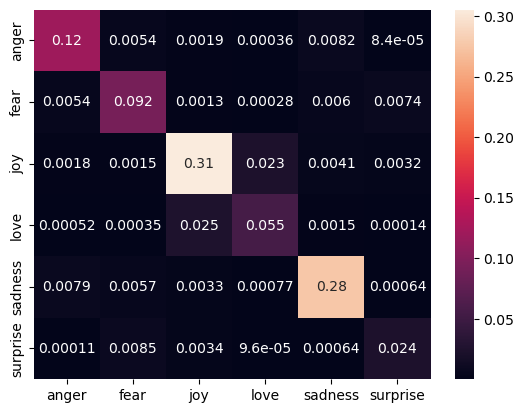

In [19]:
#Applying Linear SVM model and fitting training data to the model
svm = LinearSVC(tol=1e-05)
svm.fit(X_train_vectorized,y_train)

#Predicting target variable
y_svm = svm.predict(X_test_vectorized)
cross_val_score_svm = cross_val_score(svm, X_test_vectorized, y_test , cv = 5)


#Calculation of various accuracy metrics
print(f'Accuracy score is {accuracy_score(y_test,y_svm)*100}%\n')
print(f"F1 score is {(f1_score(y_test,y_svm,average='weighted')*100)}\n")
print(f'Cross validation Score is : \n{cross_val_score_svm}\n')
print('Confusion matrix :')
print(confusion_matrix(y_test,y_svm))
print('\n')
print('Classification report : ')
print(classification_report(y_test,y_svm))
print('\n')
cm_svm = pd.DataFrame(confusion_matrix(y_test,y_svm,normalize='all'),
                 index=['anger','fear','joy','love','sadness','surprise'],
                 columns=['anger','fear','joy','love','sadness','surprise'])
sns.heatmap(cm_svm, annot=True)

From the above observations, we find that the best fit model for our classification task would be LinearSVC as it gives more focus to less weighted classes of emotions. So, we prefer LinearSVC for our project.

### Applying Sklearn Pipelines

Here, we are applying scikit-learn pipelines for better performance.

In [15]:
pipe_svc = Pipeline(steps=[('tfidf',TfidfVectorizer(stop_words=stopwords,sublinear_tf=True, norm='l2', ngram_range=(1, 2)))
                           ,('lr', LinearSVC(tol=1e-05))])
pipe_svc.fit(X_train,y_train)
pipe_svc.score(X_test,y_test)

0.8720520141071472

### Saving model

Here, we save the model in pickle form using joblib for future uses

In [16]:
import joblib
pipe_file = open("svm_classifier.pkl","wb")
joblib.dump(pipe_svc,pipe_file)
pipe_file.close()